# Food Desert Mobile Market Route Optimization
For Feeding America's "Oasis" Mobile Farmers Market Initiative

# 1. Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import networkx as nx
import folium
from folium.plugins import MarkerCluster
import contextily as ctx
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist, pdist
from tqdm import tqdm
from IPython.display import display, HTML
import warnings

In [2]:
# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

In [3]:
# Set display options
pd.set_option('display.max_columns', None)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Set plotting parameters for consistent style
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [6]:
# Define a custom color palette for consistent visualizations
COLORS = {
    'main': '#2C3E50',       # Dark blue-gray
    'accent': '#E74C3C',     # Red
    'highlight': '#3498DB',  # Blue
    'light': '#ECF0F1',      # Light gray
    'sequential': ['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c',
                   '#fc4e2a', '#e31a1c', '#bd0026', '#800026']  # Yellow to Red
}

In [7]:
# Custom functions
def format_number(num):
    """Format numbers with commas for thousands"""
    return f"{num:,.1f}" if isinstance(num, float) else f"{num:,}"

In [8]:
def create_basemap(width=12, height=10):
    """Create a base figure for mapping"""
    fig, ax = plt.subplots(figsize=(width, height))
    return fig, ax

# 2. Data Loading and Preprocessing

In [9]:
print("\n📊 Loading and preprocessing Texas food desert data...")


📊 Loading and preprocessing Texas food desert data...


In [10]:
# Define file paths - adjust these paths based on your actual file locations
FOOD_DESERT_FILE = './drive/MyDrive/Project5:FoodDeserts/Food Desert Atlas Data/Food Atlas CSV/FoodDeserts2015.csv'
TEXAS_SHAPEFILE = "./drive/MyDrive/Project5:FoodDeserts/Texas Census Tract \'15 (tl_2015_48_tract)/tl_2015_48_tract.shp"

In [11]:
# Load Food Desert Data
print("Loading Food Desert Atlas data...")
food_desert_df = pd.read_csv(FOOD_DESERT_FILE)
print(f"Loaded {food_desert_df.shape[0]:,} rows from Food Desert Atlas data")

Loading Food Desert Atlas data...
Loaded 72,864 rows from Food Desert Atlas data


In [12]:
# Filter to Texas food deserts with LILA (Low Income, Low Access) tracts
print("Filtering to Texas food deserts with LILA tracts...")
food_desert_df = food_desert_df[['CensusTract', 'State', 'County', 'LALOWI1_20', 'LILATracts_1And20']]
texas_food_desert_df = food_desert_df[food_desert_df['State'] == 'Texas']
texas_food_desert_df = texas_food_desert_df[texas_food_desert_df['LILATracts_1And20'] == 1]
texas_food_desert_df = texas_food_desert_df.drop(columns=['LILATracts_1And20'])

Filtering to Texas food deserts with LILA tracts...


In [13]:
# Load Texas Census Tract shapefile
print("Loading Texas Census Tract shapefile...")
texas_geo_df = gpd.read_file(TEXAS_SHAPEFILE)
texas_geo_df = texas_geo_df.to_crs("EPSG:4326")  # Reproject to standard lat/lon

Loading Texas Census Tract shapefile...


In [14]:
# Convert data types for proper joining
texas_geo_df['GEOID'] = texas_geo_df['GEOID'].astype(str)
texas_food_desert_df['CensusTract'] = texas_food_desert_df['CensusTract'].astype(str)

In [15]:
# Extract lat/lon information for each tract
geo_latlon_df = texas_geo_df[['GEOID', 'INTPTLAT', 'INTPTLON']]

In [16]:
# Check how many tracts match between the datasets
common_tracts = set(texas_food_desert_df['CensusTract']).intersection(set(geo_latlon_df['GEOID']))
print(f"\nNumber of common tracts: {len(common_tracts):,}")
print(f"Total food desert tracts: {len(texas_food_desert_df):,}")
print(f"Total geo tracts: {len(geo_latlon_df):,}")


Number of common tracts: 965
Total food desert tracts: 965
Total geo tracts: 5,265


Analysis Comment: The full match between common tracts and food desert tracts indicates we have geographic data for all our identified food deserts, providing a complete datasetfor our route optimization analysis. This is crucial for ensuring we can accurately map and plan routes to serve all affected communities.

In [17]:
# Merge the lat/lon data with the food desert data
print("\nMerging dataframes...")
texas_food_desert_df = texas_food_desert_df.merge(
    geo_latlon_df,
    left_on='CensusTract',
    right_on='GEOID',
    how='inner'  # Only keep tracts that match
)


Merging dataframes...


In [18]:
# Convert string lat/lon to float
texas_food_desert_df['LAT'] = texas_food_desert_df['INTPTLAT'].str.replace('+', '').astype(float)
texas_food_desert_df['LON'] = texas_food_desert_df['INTPTLON'].astype(float)

print(f"Loaded {len(texas_food_desert_df):,} food desert census tracts in Texas")
print("Sample data:")
display(texas_food_desert_df.head())

Loaded 965 food desert census tracts in Texas
Sample data:


,CensusTract,State,County,LALOWI1_20,GEOID,INTPTLAT,INTPTLON,LAT,LON
0,48001950500,Texas,Anderson,1508.448500,48001950500,+31.7878081,-095.6419012,31.787808,-95.641901
1,48001950600,Texas,Anderson,1773.149844,48001950600,+31.7502049,-095.6692086,31.750205,-95.669209
2,48005000400,Texas,Angelina,930.881586,48005000400,+31.3415939,-094.7543239,31.341594,-94.754324
3,48005000500,Texas,Angelina,1356.270450,48005000500,+31.3708474,-094.7362500,31.370847,-94.736250
4,48005000600,Texas,Angelina,1384.213758,48005000600,+31.3505991,-094.6970483,31.350599,-94.697048


# 3. Data Exploration and Visualization

In [37]:
# Save the hidalgo dataframe
print("Saving Texas Food Desert Dataset")
texas_food_desert_df.to_csv('./data/texas_food_desert.csv')

# Create a copy for analysis
analysis_df = texas_food_desert_df.copy()

print("\n🔍 Exploring food desert data...")
print(f"Exploring the full dataset of {len(analysis_df):,} food desert locations")

Saving Texas Food Desert Dataset

🔍 Exploring food desert data...
Exploring the full dataset of 965 food desert locations


## 3.1 Distribution of population in food deserts

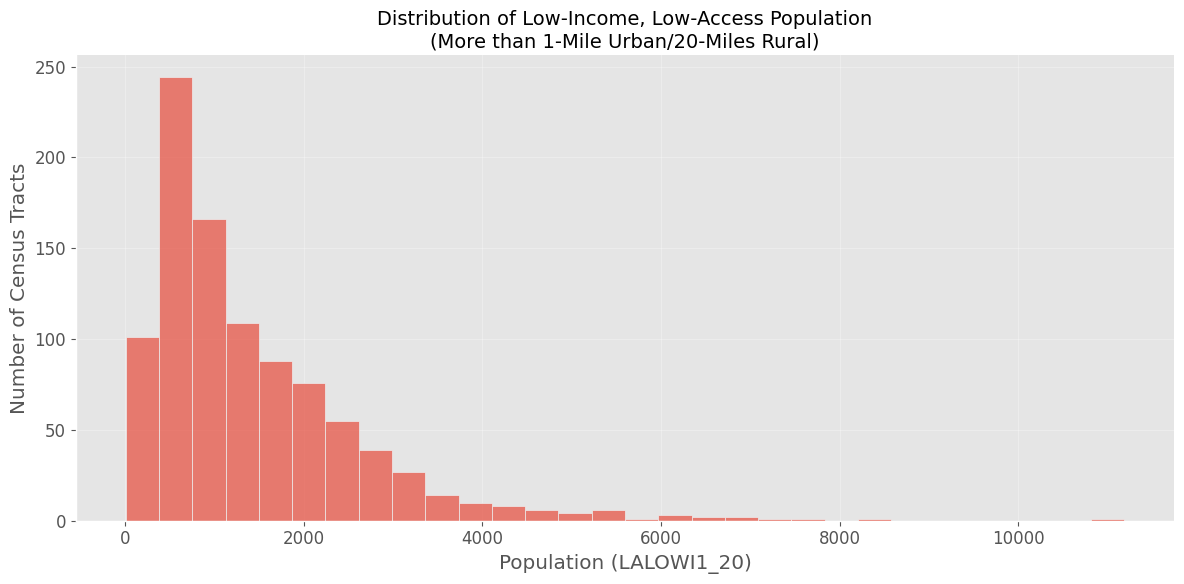

In [20]:
plt.figure(figsize=(12, 6))
sns.histplot(data=analysis_df, x='LALOWI1_20', bins=30, color=COLORS['accent'], alpha=0.7)
plt.title('Distribution of Low-Income, Low-Access Population\n(More than 1-Mile Urban/20-Miles Rural)', fontsize=14)
plt.xlabel('Population (LALOWI1_20)')
plt.ylabel('Number of Census Tracts')
plt.tight_layout()
plt.show()


Analysis Comment: The histogram reveals a right-skewed distribution, indicating that most food desert census tracts have relatively smaller affected populations (under 2,000 people), while a few tracts have much larger affected populations. This suggests we should prioritize those few high-population food deserts for maximum impact, while also designing routes that can efficiently serve the more numerous smaller population areas.

## 3.2 Top counties with food deserts

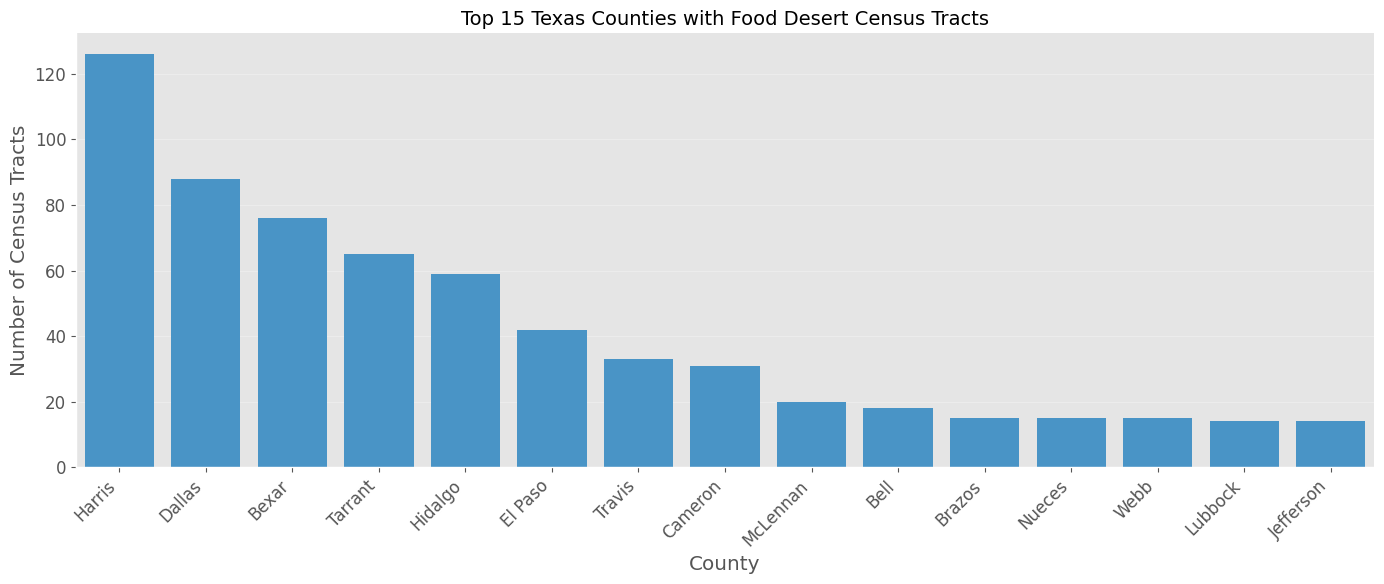

In [21]:
plt.figure(figsize=(14, 6))
county_counts = analysis_df['County'].value_counts().head(15)
sns.barplot(x=county_counts.index, y=county_counts.values, palette=[COLORS['highlight']])
plt.title('Top 15 Texas Counties with Food Desert Census Tracts', fontsize=14)
plt.xlabel('County')
plt.ylabel('Number of Census Tracts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Analysis Comment: Harris County (containing Houston) has significantly more food desert census tracts than any other county in Texas, followed by Dallas, Bexar (San Antonio), and Tarrant (Fort Worth). This concentration in major urban areas suggests that our mobile market program should focus on these metropolitan regions first, where we can reach the highest number of food desert tracts with fewer resources. The urban concentration also means shorter travel distances between stops compared to rural deployments.

## 3.3 Population affected by food deserts per county

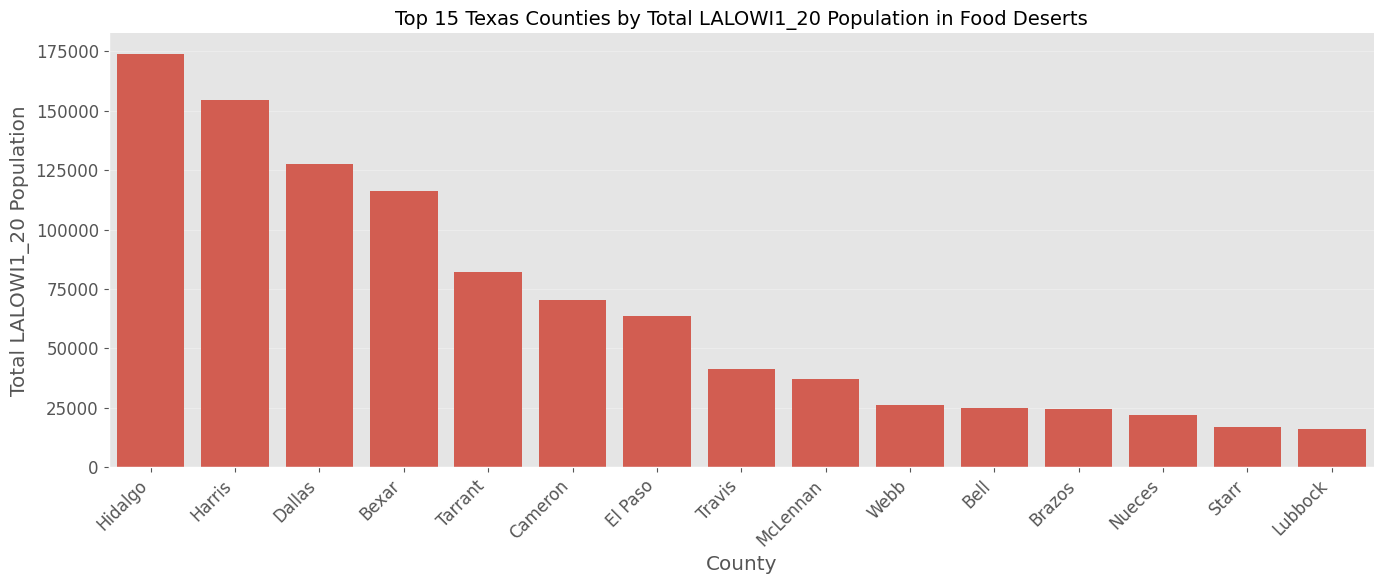

In [22]:
plt.figure(figsize=(14, 6))
county_pop = analysis_df.groupby('County')['LALOWI1_20'].sum().sort_values(ascending=False).head(15)
sns.barplot(x=county_pop.index, y=county_pop.values, palette=[COLORS['accent']])
plt.title('Top 15 Texas Counties by Total LALOWI1_20 Population in Food Deserts', fontsize=14)
plt.xlabel('County')
plt.ylabel('Total LALOWI1_20 Population')
plt.xticks(rotation=45, ha='right')
plt.ticklabel_format(style='plain', axis='y')  # Prevent scientific notation
plt.tight_layout()
plt.show()

Analysis Comment: When we look at the actual population affected by food deserts, Hidalgo County (border region) rises to the top despite having fewer total food desert tracts.

This indicates a higher density of low-income, low-access population in this border county.

Our route planning should consider population density rather than just the number of tracts.

Hidalgo County should be prioritized as an initial deployment site for the Oasis Mobile Market due to its high impact potential.

## 3.4 Visualize food desert locations with population

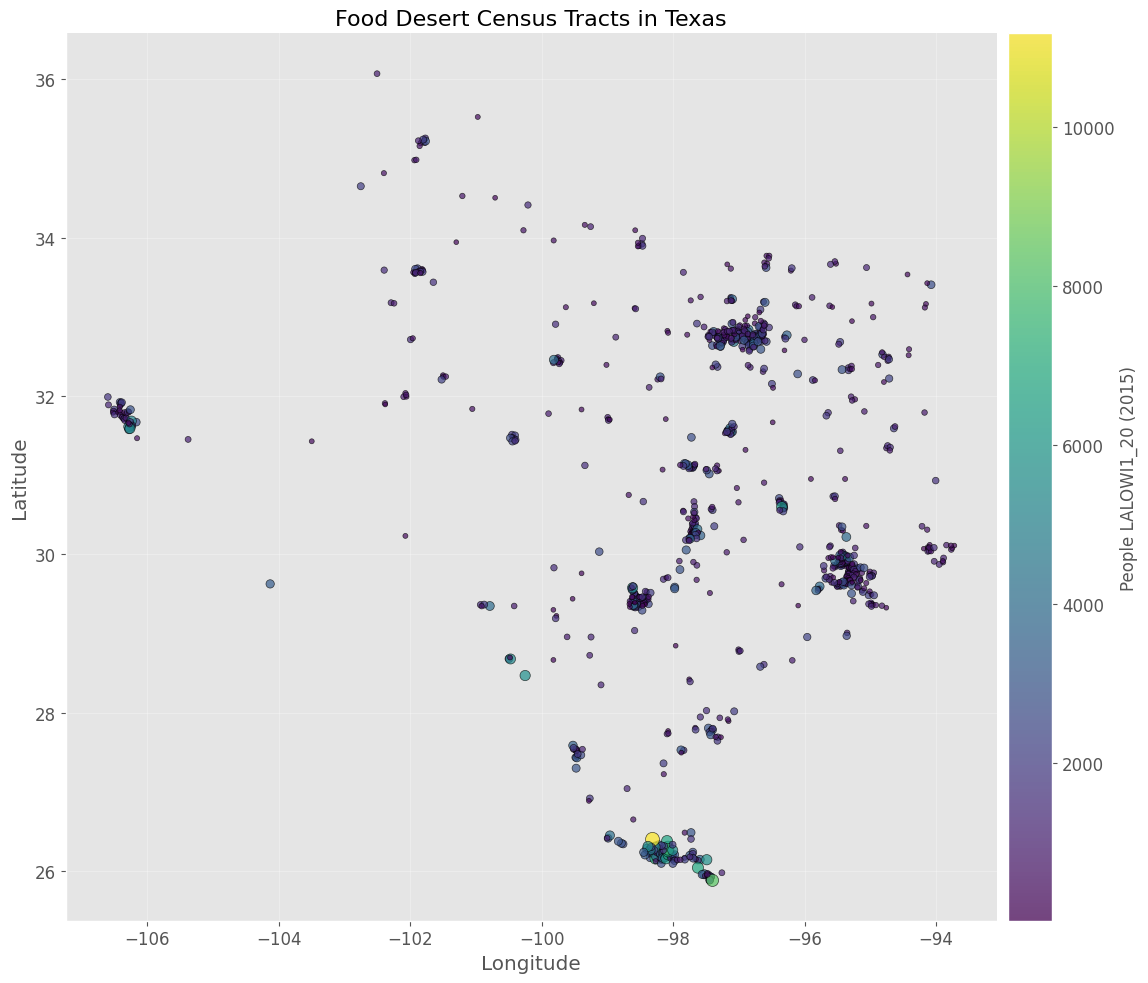

In [23]:
fig, ax = plt.subplots(figsize=(12, 10))

# Create a continuous colormap based on population
# Handle any potential NaN values
analysis_df_plot = analysis_df.dropna(subset=['LALOWI1_20', 'LON', 'LAT'])

norm = plt.Normalize(analysis_df_plot['LALOWI1_20'].min(), analysis_df_plot['LALOWI1_20'].max())
cmap = plt.cm.viridis

# Make point sizes more consistent but still reflect population
min_size = 10  # Minimum point size
max_size = 100  # Maximum point size
pop_min = analysis_df_plot['LALOWI1_20'].min()
pop_max = analysis_df_plot['LALOWI1_20'].max()

# Calculate point sizes with a more balanced scale
point_sizes = min_size + ((analysis_df_plot['LALOWI1_20'] - pop_min) / (pop_max - pop_min)) * (max_size - min_size)

scatter = ax.scatter(
    analysis_df_plot['LON'],
    analysis_df_plot['LAT'],
    alpha=0.7,
    c=analysis_df_plot['LALOWI1_20'],
    cmap=cmap,
    s=point_sizes,  # More balanced point sizing
    edgecolor='k',
    linewidth=0.5
)

cbar = plt.colorbar(scatter, ax=ax, pad=0.01)
cbar.set_label('People LALOWI1_20 (2015)', fontsize=12)
plt.title('Food Desert Census Tracts in Texas', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

Analysis Comment: The spatial distribution of food deserts across Texas shows several clear patterns. Major clusters appear around urban centers (Houston, Dallas-Fort Worth, San Antonio, and Austin) and along the Texas-Mexico border. The Rio Grande Valley region (southmost part of Texas) shows particularly high population density in food deserts.

We also observe smaller clusters in East Texas and scattered rural food deserts throughout the state. This geographical pattern suggests we should develop multiple hub-and-spoke models for our mobile markets rather than a single statewide route.

## 3.5 Calculate summary statistics

In [24]:
print("\n📊 Summary Statistics:")
print(f"Total number of food desert census tracts: {len(analysis_df):,}")
print(f"Total population in food deserts: {analysis_df['LALOWI1_20'].sum():,.0f}")
print(f"Average population per tract: {analysis_df['LALOWI1_20'].mean():.1f}")
print(f"Median population per tract: {analysis_df['LALOWI1_20'].median():.1f}")
print(f"Minimum population in a tract: {analysis_df['LALOWI1_20'].min():.1f}")
print(f"Maximum population in a tract: {analysis_df['LALOWI1_20'].max():.1f}")


📊 Summary Statistics:
Total number of food desert census tracts: 965
Total population in food deserts: 1,383,354
Average population per tract: 1433.5
Median population per tract: 1055.8
Minimum population in a tract: 10.0
Maximum population in a tract: 11183.0


Analysis Comment: The substantial difference between mean (1,433.5) and median (1,055.8) population values confirms the right-skewed distribution observed earlier. With a maximum population of over 11,000 in a single tract compared to tracts with just 10 people, we see extreme variability in the affected population sizes. The total affected population of approximately 1.38 million people represents about 5% of Texas's total population, highlighting the scale of the food access problem. Our mobile market strategy should incorporate both high-density and low-density approaches to serve these diverse communities.

# 4. Map Visualization with Population Density

In [25]:
print("\n🗺️ Creating density map visualization...")


🗺️ Creating density map visualization...


## 4.1 Filter to LILA tracts only

In [26]:
lila_geo_df = texas_geo_df[texas_geo_df['GEOID'].isin(texas_food_desert_df['CensusTract'])]
lila_geo_df = lila_geo_df.to_crs(epsg=3081)  # Texas-specific projection
lila_geo_df['centroid'] = lila_geo_df.geometry.centroid

## 4.2 Reproject the Texas base map to match

In [27]:
texas_geo_df_proj = texas_geo_df.to_crs(epsg=3081)

## 4.3 Plot map of LILA tract centroids

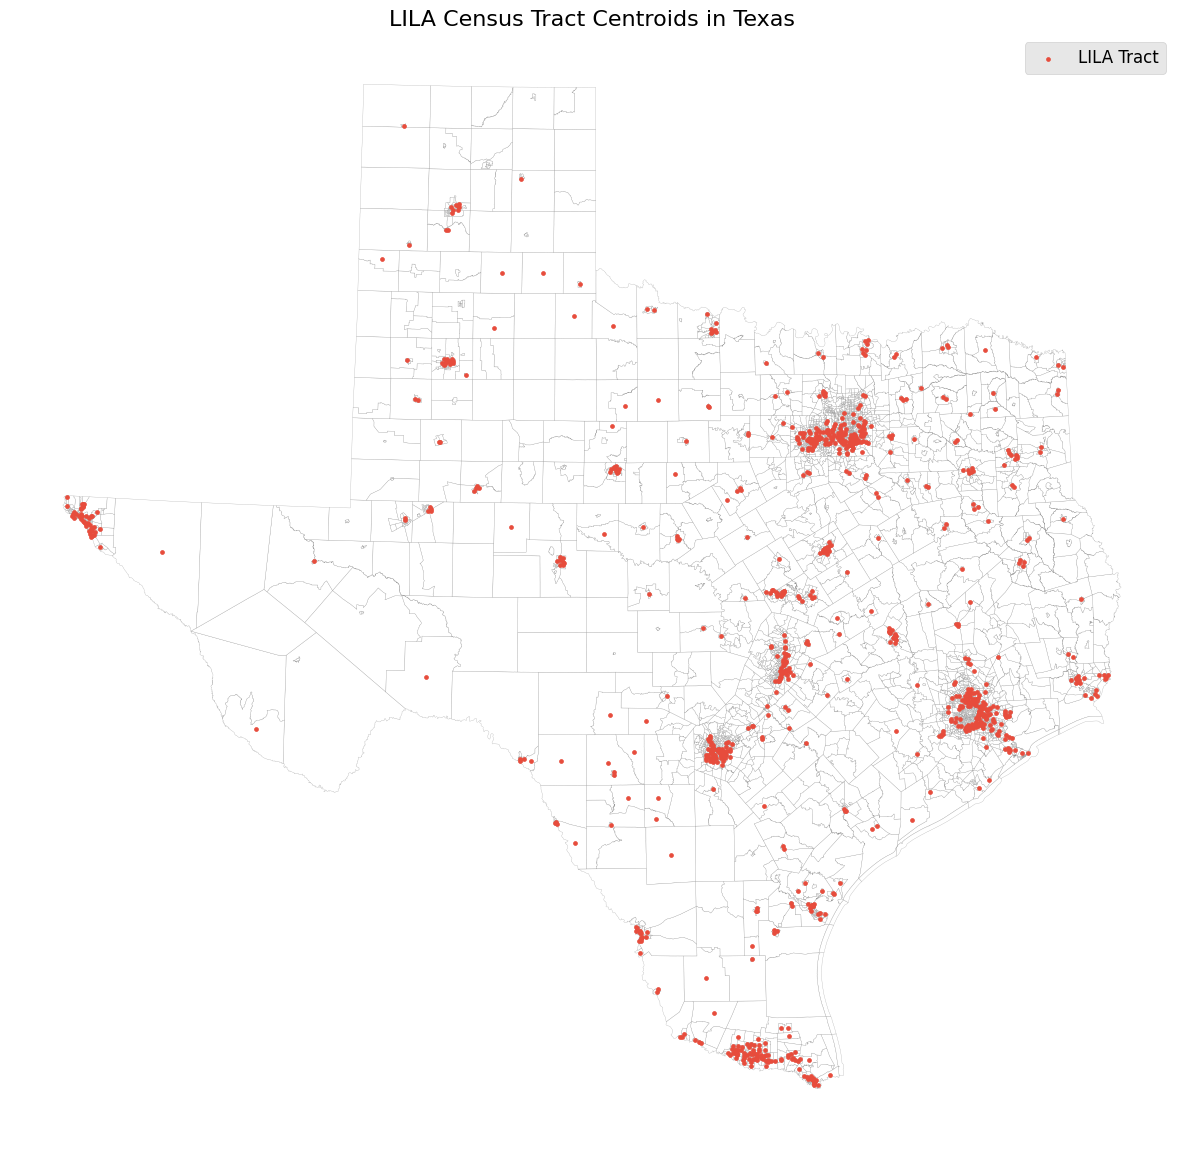

In [28]:
fig, ax = plt.subplots(figsize=(12, 12))
texas_geo_df_proj.plot(ax=ax, facecolor='white', edgecolor='gray', linewidth=0.2, alpha=0.7)
lila_geo_df.set_geometry('centroid').plot(
    ax=ax,
    color=COLORS['accent'],
    markersize=8,
    label='LILA Tract'
)

plt.title('LILA Census Tract Centroids in Texas', fontsize=16)
plt.legend(loc='upper right', frameon=True, framealpha=0.9)
plt.axis('off')
plt.tight_layout()
plt.show()

Analysis Comment: Visualizing the centroids of each LILA (Low Income, Low Access) tract provides clear target points for our mobile market stops. The centroids can serve as potential stopping locations for our mobile markets, allowing us to efficiently reach the geometric centers of each food desert area. This visualization confirms the regional clustering we observed earlier and will be crucial for dividing the state into manageable service regions for different mobile market units.


## 4.4 Create a population density map

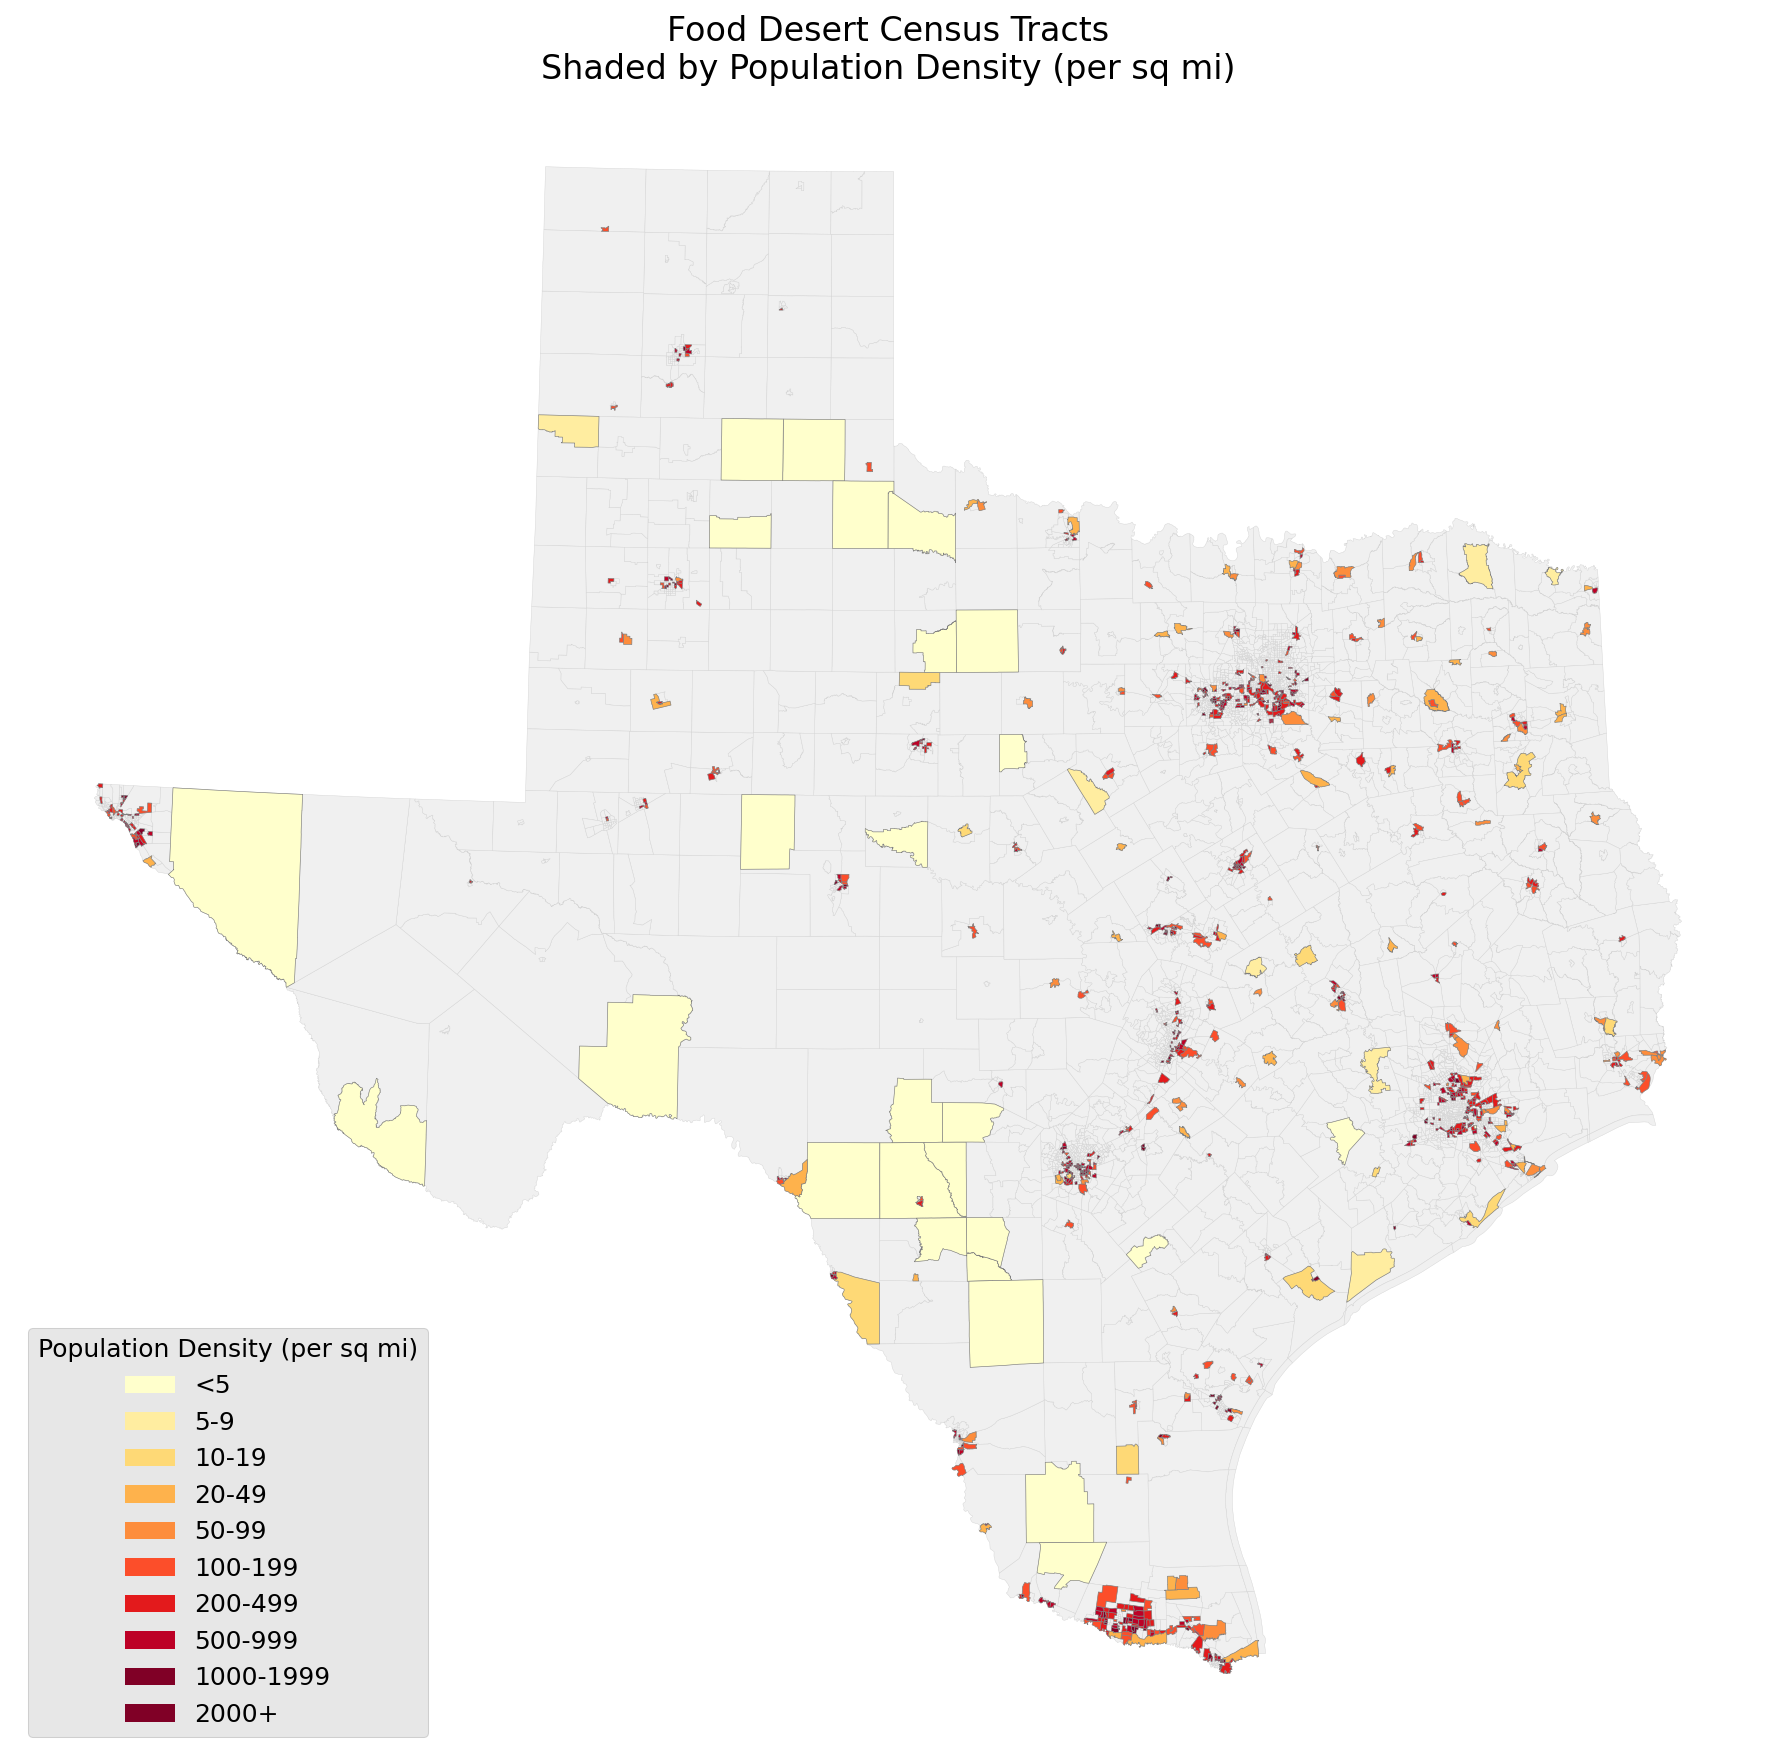

In [29]:
texas_geo_df_proj = texas_geo_df_proj.merge(
    texas_food_desert_df[['CensusTract', 'LALOWI1_20']],
    left_on='GEOID',
    right_on='CensusTract',
    how='left'  # keeps all tracts, fills NaN for non-matching
)

# Compute population density
texas_geo_df_proj['ALAND_miles'] = texas_geo_df_proj['ALAND'] / 2.59e+6  # convert sq meters to sq miles
texas_geo_df_proj['POP_density'] = texas_geo_df_proj['LALOWI1_20'] / texas_geo_df_proj['ALAND_miles']

# Define bins, labels, and colors for population density
bins = [-np.inf, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, np.inf]
labels = [
    '<5', '5-9', '10-19', '20-49', '50-99',
    '100-199', '200-499', '500-999', '1000-1999', '2000+'
]
colors = COLORS['sequential']

# Create color map - ensure we have exactly enough colors for all labels
if len(colors) < len(labels):
    # Add extra colors if needed using the last color
    colors = colors + [colors[-1]] * (len(labels) - len(colors))
elif len(colors) > len(labels):
    # Trim extra colors if needed
    colors = colors[:len(labels)]

color_map = dict(zip(labels, colors))

# Filter to LILA tracts only for density map
lila_tracts = texas_geo_df_proj[texas_geo_df_proj['GEOID'].isin(lila_geo_df['GEOID'])]

# Bin LILA tracts and assign colors
# First, handle NaN values in POP_density
lila_tracts['POP_density'] = lila_tracts['POP_density'].fillna(0)

lila_tracts['density_bin'] = pd.cut(
    lila_tracts['POP_density'],
    bins=bins,
    labels=labels,
    include_lowest=True
)
# Ensure we don't have NaN values in density_bin
lila_tracts['density_bin'] = lila_tracts['density_bin'].fillna(labels[0])  # Assign lowest bin to NaN values
lila_tracts['color'] = lila_tracts['density_bin'].map(color_map)

# Plotting LILA tracts more efficiently
# Handle potential missing or NaN values in density_bin
lila_tracts['density_bin'] = lila_tracts['density_bin'].fillna(labels[0])

# Safely create a list of colors - with a fallback for any missing mappings
color_list = []
for bin_value in lila_tracts['density_bin']:
    if bin_value in color_map:
        color_list.append(color_map[bin_value])
    else:
        # Use a default color if the bin value isn't in our map
        color_list.append('#dddddd')  # Light gray as fallback

# Create the density map
fig, ax = plt.subplots(1, 1, figsize=(12, 12), dpi=150)
plt.title('Food Desert Census Tracts\nShaded by Population Density (per sq mi)', fontsize=16)

# Plot all of Texas in light gray
texas_geo_df_proj.plot(
    ax=ax,
    color='#f0f0f0',
    edgecolor='lightgray',
    linewidth=0.2
)

# Plot LILA tracts all at once with a list of colors
lila_tracts.plot(
    ax=ax,
    color=color_list,
    edgecolor='gray',
    linewidth=0.3
)

# Build custom legend
legend_elements = [Patch(facecolor=color_map[label], label=label) for label in labels]
plt.legend(
    handles=legend_elements,
    title='Population Density (per sq mi)',
    loc='lower left',
    frameon=True,
    framealpha=0.9
)

plt.axis('off')
plt.tight_layout()
plt.show()

Analysis Comment: The population density map provides critical insights for our route optimization.

The highest density food deserts (dark red) are concentrated in very specific locations: the Rio Grande Valley, central Houston, parts of Dallas-Fort Worth, and pockets in San Antonio.

These high-density areas should become primary hubs for our mobile markets as they allow us to reach more people with fewer stops. Medium-density areas (orange) could serve as secondary hubs, while lower-density regions (yellow) might be served with less frequent visits.

The stark contrast between high-density urban food deserts and low-density rural ones suggests we need at least two different service models to address these distinct contexts.

# 6. Focus on specific county (e.g., Hidalgo)

In [32]:
county_of_interest = 'Hidalgo'
hidalgo_df = analysis_df[analysis_df['County'] == county_of_interest].copy()
print(f"\n🔍 Focus on {county_of_interest} County:")
print(f"Number of food desert tracts: {len(hidalgo_df)}")
print(f"Total affected population: {hidalgo_df['LALOWI1_20'].sum():,.0f}")


🔍 Focus on Hidalgo County:
Number of food desert tracts: 59
Total affected population: 173,795


Analysis Comment: Based on our previous findings, we're focusing on Hidalgo County as our initial deployment target. With a high concentration of affected populationin a relatively compact geographic area, Hidalgo County presents an ideal test case for our mobile market model. The region's border location also highlights the unique challenges of food access in communities that may face additional economic and infrastructure barriers. Lessons learned from optimizing routes in this high-impact county can inform our expansion to other regions of Texas.


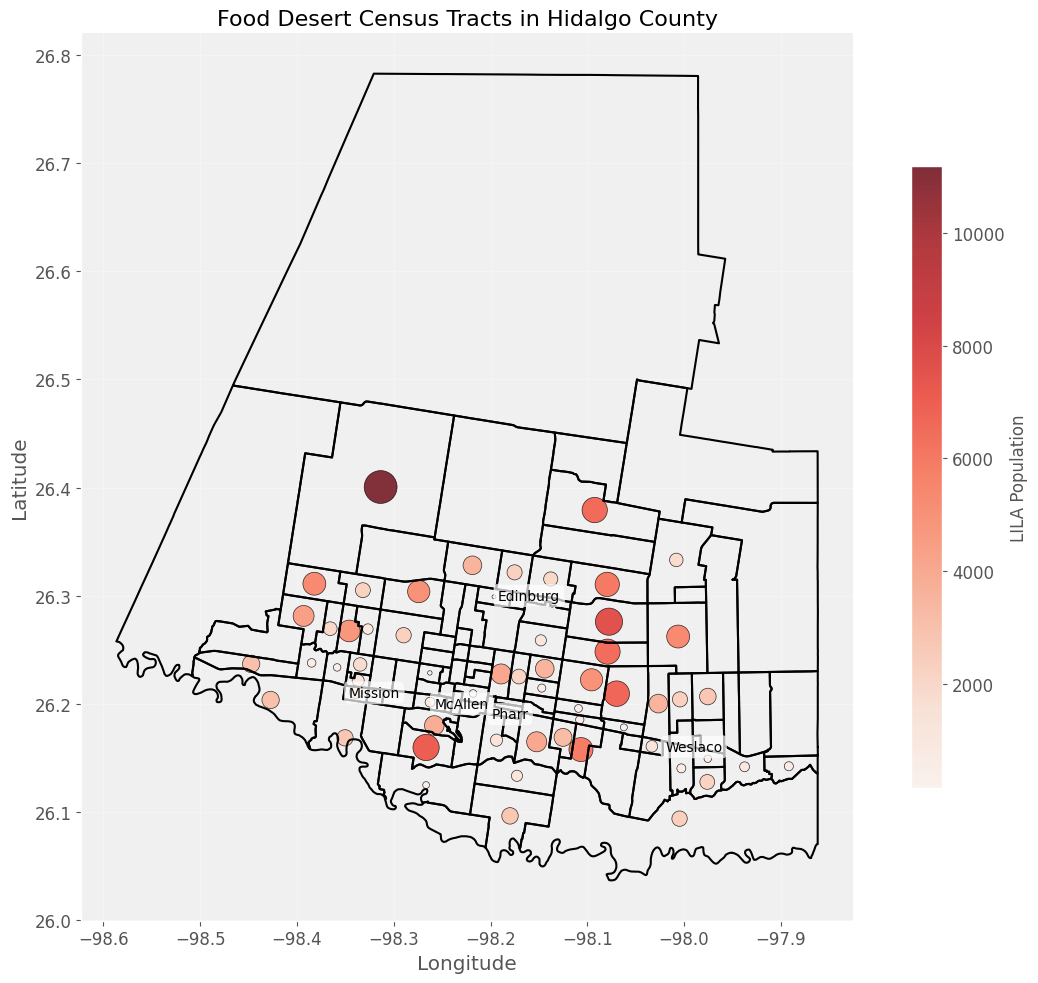

In [33]:
# Create a detailed map of our focus county
fig, ax = plt.subplots(figsize=(12, 10))

# Get county boundaries
hidalgo_boundary = texas_geo_df[texas_geo_df['GEOID'].str.startswith('48215')].to_crs(epsg=4326)

# Background for context
ax.set_facecolor('#f0f0f0')

# Plot Hidalgo County boundary
hidalgo_boundary.boundary.plot(ax=ax, linewidth=1.5, color='black')

# Create a custom colormap for population
custom_cmap = plt.cm.Reds

# Plot food desert locations with size and color by population
scatter = ax.scatter(
    hidalgo_df['LON'],
    hidalgo_df['LAT'],
    s=hidalgo_df['LALOWI1_20'] / 20,  # Scale down for better visibility
    c=hidalgo_df['LALOWI1_20'],
    cmap=custom_cmap,
    alpha=0.8,
    edgecolor='black',
    linewidth=0.5
)

# Add a colorbar for population
cbar = plt.colorbar(scatter, ax=ax, shrink=0.7)
cbar.set_label('LILA Population', fontsize=12)

# Label the map
plt.title(f'Food Desert Census Tracts in {county_of_interest} County', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add annotations for major locations if desired
# Note: You may need to adjust these coordinates for your actual data
major_locations = {
    'McAllen': [-98.23, 26.20],
    'Edinburg': [-98.16, 26.30],
    'Mission': [-98.32, 26.21],
    'Pharr': [-98.18, 26.19],
    'Weslaco': [-97.99, 26.16]
}

for city, (lon, lat) in major_locations.items():
    plt.text(lon, lat, city, fontsize=10, ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))

plt.tight_layout()
plt.show()

In [34]:
# Calculate statistics for Hidalgo County
print("\nHidalgo County Food Desert Statistics:")
print(f"Average population per tract: {hidalgo_df['LALOWI1_20'].mean():.1f}")
print(f"Highest population tract: {hidalgo_df['LALOWI1_20'].max():.1f}")
print(f"Total area to cover: {hidalgo_boundary['ALAND'].sum() / 2.59e+6:.1f} sq miles")



Hidalgo County Food Desert Statistics:
Average population per tract: 2945.7
Highest population tract: 11183.0
Total area to cover: 1570.9 sq miles


Analysis Comment: The Hidalgo County map reveals concentrated food desert areas primarily along the US-Mexico border and around the major population centers.

The higher population densities in these areas make them efficient targets for mobile market deployments, potentially serving many people with fewer stops.

This visualization will help us develop targeted routes that can efficiently reach the largest number of food desert residents.

# 6. Next Steps for Route Optimization

In [35]:
print("\n🚚 Next steps for route optimization:")
print("1. Cluster food desert locations into service regions")
print("2. Determine optimal hub locations for each service region")
print("3. Calculate efficient routes from hubs to food desert locations")
print("4. Optimize scheduling based on population needs and travel times")
print("5. Estimate impact metrics for different routing scenarios")


🚚 Next steps for route optimization:
1. Cluster food desert locations into service regions
2. Determine optimal hub locations for each service region
3. Calculate efficient routes from hubs to food desert locations
4. Optimize scheduling based on population needs and travel times
5. Estimate impact metrics for different routing scenarios


Analysis Comment: Our exploratory analysis has provided the foundation for route optimization.

The next phase will involve applying network analysis and clustering algorithms to determine the most efficient routes for mobile markets. By dividing the state into distinct service regions based on both geographic proximity and population density, we can create a scalable model that maximizes the impact of each mobile market unit. For areas like Hidalgo County, we'll develop detailed routing plans that minimize travel time while maximizing population reach, ensuring the Oasis Initiative delivers fresh food efficiently to those who need it most.